<a href="https://colab.research.google.com/github/jacson981206/jacson981206/blob/main/Tiempo_Real_UV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**TIEMPO REAL**

###**Importar Librerías**

In [1]:
#-------------------------------------
#-----------modelo Proyecto---------------------
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import pandas as pd
#----------------------------------------------------
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
#-------------------------------------------------------------
# import the required image preprocessing functions
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import decode_predictions

# import the models for further classification experiments
from tensorflow.keras.applications import (
        vgg16,
        resnet50,
        mobilenet,
        inception_v3
    )

import matplotlib.pyplot as plt
import numpy as np

# imports for reproducibility
import tensorflow as tf
import random
import os

%matplotlib inline

from google.colab import drive #Unidad de víctimas
drive.mount('/content/drive')  #En este momento, montar el drive de Jacson

Mounted at /content/drive


###**Cargar Modelo**

In [ ]:
# init the models

vgg_model = vgg16.VGG16(weights='imagenet')

inception_model = inception_v3.InceptionV3(weights='imagenet')

resnet_model = resnet50.ResNet50(weights='imagenet')

mobilenet_model = mobilenet.MobileNet(weights='imagenet')

553467096/553467096 [==============================] - 25s 0us/step


In [2]:
# model=load_model('/content/drive/MyDrive/PROYECTO_DE_GRADO/VGG16/model_save/VGG16FC_TL&FT/VGG16FC_TL&FT_ep23-val_loss0.01.keras')
# model=load_model('/content/drive/MyDrive/PROYECTO_DE_GRADO/VGG16/model_save/VGG16FC_TL/VGG16FC_TL_ep13-val_loss0.04.keras')
# model=load_model('/content/drive/MyDrive/model_save/MovileNetV2_TL_&_FT.h5')
class_names = np.load("/content/drive/MyDrive/PROYECTO_DE_GRADO/VGG16_V1/clases/clases.npy")

In [3]:
checkpoint_dir = "/content/drive/MyDrive/PROYECTO_DE_GRADO/VGG16_V1/model_save"
checkpoints = [checkpoint_dir + "/VGG16FC_TL&FT/" + name for name in os.listdir(checkpoint_dir + "/VGG16FC_TL&FT/")];checkpoints

['/content/drive/MyDrive/PROYECTO_DE_GRADO/VGG16_V1/model_save/VGG16FC_TL&FT/VGG16FC_TL&FT_ep14-val_loss0.025.keras',
 '/content/drive/MyDrive/PROYECTO_DE_GRADO/VGG16_V1/model_save/VGG16FC_TL&FT/VGG16FC_TL&FT_ep15-val_loss0.011.keras',
 '/content/drive/MyDrive/PROYECTO_DE_GRADO/VGG16_V1/model_save/VGG16FC_TL&FT/VGG16FC_TL&FT_ep17-val_loss0.011.keras',
 '/content/drive/MyDrive/PROYECTO_DE_GRADO/VGG16_V1/model_save/VGG16FC_TL&FT/VGG16FC_TL&FT_ep20-val_loss0.008.keras',
 '/content/drive/MyDrive/PROYECTO_DE_GRADO/VGG16_V1/model_save/VGG16FC_TL&FT/VGG16FC_TL&FT_ep22-val_loss0.005.keras']

In [27]:
#latest_checkpoint = max(checkpoints, key=os.path.getctime);print('mejor modelo:',latest_checkpoint.split('/')[-1])
latest_checkpoint = '/content/drive/MyDrive/PROYECTO_DE_GRADO/VGG16224/model_save/VGG16FC_TL&FT/VGG16FC_TL&FT_ep20-val_loss0.007.keras'; latest_checkpoint

'/content/drive/MyDrive/PROYECTO_DE_GRADO/VGG16224/model_save/VGG16FC_TL&FT/VGG16FC_TL&FT_ep20-val_loss0.007.keras'

In [28]:
model=tf.keras.models.load_model(latest_checkpoint)  #poner aqui el archivo
model.summary(line_length=120)

Model: "model_fc"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input (InputLayer)                                   [(None, 224, 224, 3)]                           0                 
                                                                                                                        
 data_aug (Sequential)                                (None, 224, 224, 3)                             0                 
                                                                                                                        
 tf.__operators__.getitem (SlicingOpLambda)           (None, 224, 224, 3)                             0                 
                                                                                                                        
 tf.nn.bias_ad

In [ ]:
#@title ####Cargar DataBase { form-width: "35%" }
image_size =  224#@param {type:"number"}
carpeta = "new_drive_procesamiento_imagenes" #@param {type:"string"}
dataset= "RECORTES4_RBG" #@param {type:"string"}
conjunto_train = "train" #@param {type:"string"}
conjunto_val= "validation" #@param {type:"string"}

custom_Model= load_model("/content/drive/MyDrive/Modelo_Completo/top_model_final_Md.h5")
train_labels_class = np.load("/content/drive/MyDrive/"+carpeta+"/"+conjunto_train+"/"+dataset[0]+dataset[8]+"_"+conjunto_train+"_labels_class_"+str(image_size)+".npy",allow_pickle = True)


In [ ]:
lb_encod = LabelEncoder()
labels_encod = pd.DataFrame(train_labels_class)
labels_encod = lb_encod.fit_transform(labels_encod[0])
labels_encod

array([0, 0, 0, ..., 7, 7, 7])

###**Ajuste de la camara**

In [29]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)
  ##################################################### nuevo YO
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [30]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 1280, 720);
          //captureCanvas.getContext('2d').drawImage(video, 0, 0, 512,512);
          // captureCanvas.getContext('2d').drawImage(video, 0, 0, 160, 160);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 1280; //video.videoWidth;
      captureCanvas.height = 720; //video.videoHeight;
      //captureCanvas.width = 512; //video.videoWidth;
      //captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

###**Abrir Camara**

In [72]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([224,224,4], dtype=np.uint8)

    #-------------------------------------------------------------------------------------------------------

    #numpy_image = img_to_array(frame)
    #image_rescal= np.resize(frame.copy(),(299,299,3))
    image_batch_224 = np.array([frame],'float32')
    #r=image_batch_224[0][0:720,280:1000]
    r=image_batch_224[0][248:472,528:752]
    array_ima=np.expand_dims(r, axis=0)
    #image_batch_299 = np.expand_dims(frame, axis=0)

    #--------------prepare the image for the VGG model
    # processed_image_vgg = vgg16.preprocess_input(image_batch_224)
    # processed_image_mobilenet = resnet50.preprocess_input(image_batch_224)
    # processed_image_resnet = mobilenet.preprocess_input(image_batch_224)
    #processed_image_inception = inception_v3.preprocess_input(image_batch_299)
    #--------------get the predicted probabilities for each class
    # predictions_vgg = vgg_model.predict(processed_image_vgg,)
    # predictions_mobilenet = resnet_model.predict(processed_image_mobilenet)
    # predictions_resnet = mobilenet_model.predict(processed_image_resnet)
    # val_pred = custom_Model.predict(image_batch_224)
    #############################################################
    # logits = model.predict(image_batch_224,verbose=0,)
    # probabilidad = tf.nn.softmax(logits=logits)
    # confianza=np.max(probabilidad,axis=1)
    # labels_predict=np.argmax(probabilidad,axis=1)
    # class_names = ['LIMON_CRIOLLO','LIMON_MANDARINO','LIMON_TAHITI','MANDARINA_ISRAELI','MANDARINA_PIELDESAPO','NARANAJA_VALENCIA','TANGELO','TORONJA']
    # class_predict = np.array(class_names)[labels_predict]
    #########################333

    probabilidad = model(array_ima, training=False)
    ##probabilidad = model.predict(array_ima,verbose=0,)
    confianza=np.max(probabilidad,axis=1)
    labels_predict=np.argmax(probabilidad,axis=1)
    class_predict = class_names[labels_predict]
    #predictions_inception = inception_model.predict(processed_image_inception)
    #--------------print predictions
    #--------------convert the probabilities to class labels
    # label_vgg = decode_predictions(predictions_vgg, top=1)
    # label_mobilenet = decode_predictions(predictions_mobilenet, top=1)
    # label_resnet = decode_predictions(predictions_resnet, top=1)
    #label_inception = decode_predictions(predictions_inception, top=1)

    # prediction_class = lb_encod.inverse_transform(np.argmax(val_pred,axis=1))
    # confi=np.max(val_pred,axis=1)

    #print(label_vgg[0][0])

    #--------------get face bounding box for overlay

    bbox_array = cv2.rectangle(bbox_array,(50,60),(50+124,60+124),(255,0,0),2)

    # bbox_array = cv2.putText(bbox_array, "VGG16: {} [{:.2f}]".format(label_vgg[0][0][1], float(label_vgg[0][0][2])),(10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

    # bbox_array = cv2.putText(bbox_array, "MobilNet: {} [{:.2f}]".format(label_mobilenet[0][0][1], float(label_mobilenet[0][0][2])),(10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

    # bbox_array = cv2.putText(bbox_array, "ResNet50: {} [{:.2f}]".format(label_resnet[0][0][1], float(label_resnet[0][0][2])),(10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

    #bbox_array = cv2.putText(bbox_array, "Insect_v3: {} [{:.2f}]".format(label_inception[0][0][1], float(label_inception[0][0][2])),(10, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

    bbox_array = cv2.putText(bbox_array, "My_Proyect: {} [{:.2f}]".format(class_predict, float(confianza)),(5, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
    #-------------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>

<ipython-input-72-902218eebe1f>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bbox_array = cv2.putText(bbox_array, "My_Proyect: {} [{:.2f}]".format(class_predict, float(confianza)),(5, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)


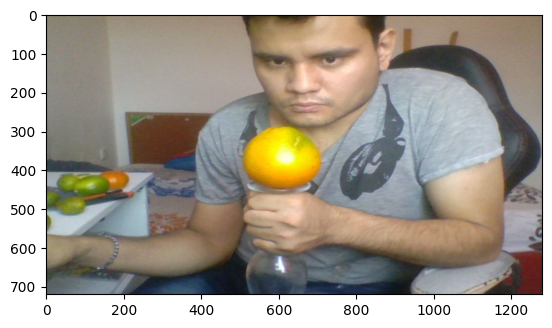

In [68]:
plt.imshow(frame)
plt.imsave('limn.jpg',frame)

###**Inferencia**

In [63]:
model.summary()

Model: "model_fc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 data_aug (Sequential)       (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0  

In [69]:
# img_path = tf.keras.utils.get_file(fname="8.jpg",origin="https://statics-cuidateplus.marca.com/cms/pomelo-blanco.jpg")
img_path = '/content/limn.jpg'
# img_path = '/content/drive/MyDrive/BD_CONFONDO_rand_s2/test/TANGELO/80_lb6.jpg'
# img = tf.keras.preprocessing.image.load_img(img_path, target_size=(500,500))
img = tf.keras.preprocessing.image.load_img(img_path, target_size=None)
# img = tf.keras.preprocessing.image.load_img(img_path, target_size=(160, 160))


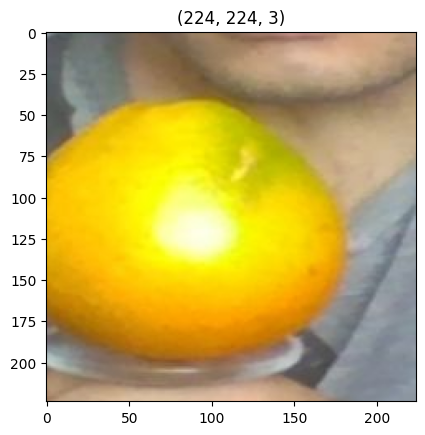

In [70]:
import matplotlib.pyplot as plt
# array = tf.keras.preprocessing.image.img_to_array(img.rotate(180))
array = tf.keras.preprocessing.image.img_to_array(img)
# array = np.expand_dims(array, axis=0)
array = np.array([array])
# processed_image_vgg = vgg16.preprocess_input(array)
# plt.axis("off")
plt.title(array_ima[0].shape)
plt.imshow(array_ima[0].astype("uint8"))
#plt.title(array[0].shape)
#plt.imshow(array[0].astype("uint8"))
plt.show()

In [71]:
# probabilidad = model.predict(array,verbose=1,)
probabilidad = model.predict(array_ima,verbose=1,)
#probabilidad = model.predict(array,verbose=1,)
confianza=np.max(probabilidad,axis=1)
labels_predict=np.argmax(probabilidad,axis=1)
class_predict = class_names[labels_predict]
print(class_predict , confianza)

1/1 [==============================] - 1s 610ms/step
['TANGELO'] [0.98699677]


In [16]:
probabilidad

array([[2.2832803e-05, 9.9123597e-01, 5.1172888e-03, 3.4424416e-03,
        1.8053064e-04, 1.3950492e-07, 8.1411190e-07, 2.2885423e-11]],
      dtype=float32)

In [ ]:
logits = model.predict(array,verbose=1,)
probabilidad = tf.nn.softmax(logits=logits)
confianza=np.max(probabilidad,axis=1)
labels_predict=np.argmax(probabilidad,axis=1)
class_predict = class_names[labels_predict]
print(class_predict , confianza)

1/1 [==============================] - 0s 21ms/step
['MANDARINA_ISRAELI'] [0.20334029]


In [ ]:
# assign the image path for the classification experiments
filename = 'images/cat.jpg'

In [ ]:
original = load_img(filename, target_size=(224, 224))
numpy_image = img_to_array(original)
image_batch = np.expand_dims(numpy_image, axis=0)


In [ ]:
# prepare the image for the VGG model
processed_image = vgg16.preprocess_input(image_batch.copy())
# get the predicted probabilities for each class
predictions = vgg_model.predict(processed_image,)
# print predictions
# convert the probabilities to class labels
# we will get top 5 predictions which is the default
label_vgg = decode_predictions(predictions,top=1)
label_vgg[0][0]

('n02123597', 'Siamese_cat', 0.30934167)

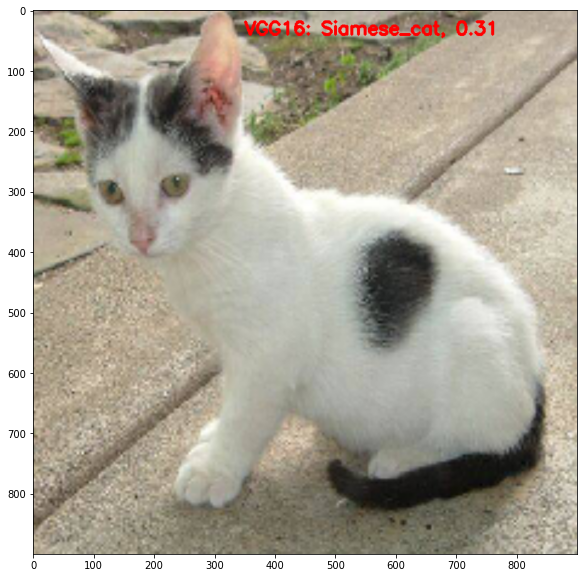

In [ ]:
numpy_image_cv2 = cv2.resize(numpy_image,(900,900))
#plt.imshow(np.uint8(numpy_image_cv2))

# format final image visualization to display the results of experiments
cv2.putText(numpy_image_cv2, "VGG16: {}, {:.2f}".format(label_vgg[0][0][1], label_vgg[0][0][2]) , (350, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

cv2.imwrite("images/{}_output.jpg".format(filename.split('/')[-1].split('.')[0]),cv2.cvtColor(numpy_image_cv2, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.axis('on')
plt.imshow(np.uint8(numpy_image_cv2))
